In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.utils import get_project_root
from src.data_statistical_features import Segment
from src.ml_statistical_features import load_data_as_dataframe

import os

# Load Data

In [2]:
df = load_data_as_dataframe(segment_length=10, overlap_amount=0, hr_threshold=15)

features = df.iloc[:,:13]
target = df['informative_hr']
mean_error = df['mean error']
coverage = df['coverage']
patient_id = df['patient_id']

# Informative per patient

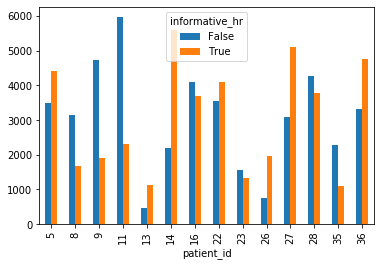

In [3]:
pd.crosstab(df['patient_id'],df['informative_hr']).plot.bar()

# Correlation Heatmap

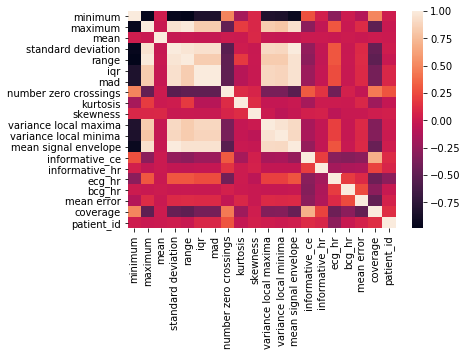

In [4]:
sns.heatmap(df.corr())

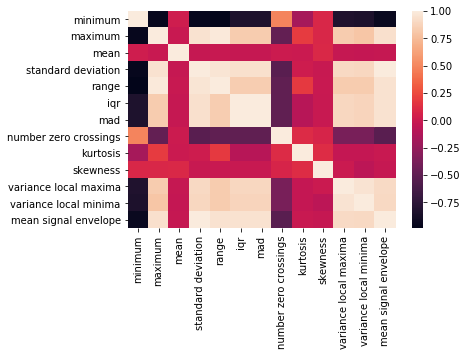

In [5]:
sns.heatmap(features.corr())

# Paarweise geplottet

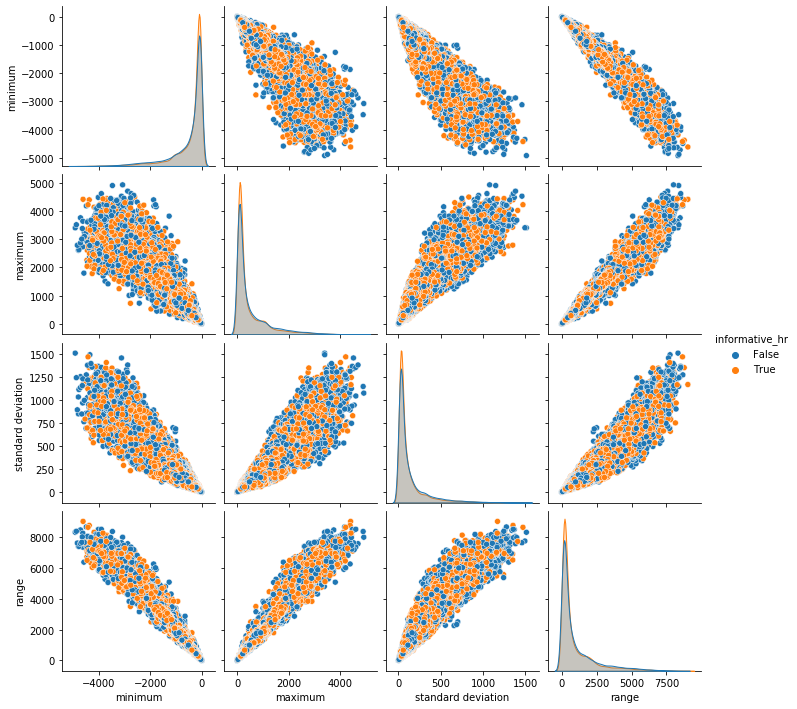

In [6]:
cols = ['minimum', 'maximum', 'standard deviation', 'range', 'informative_hr']
sns.pairplot(df[cols], kind='scatter', hue='informative_hr', dropna=True)

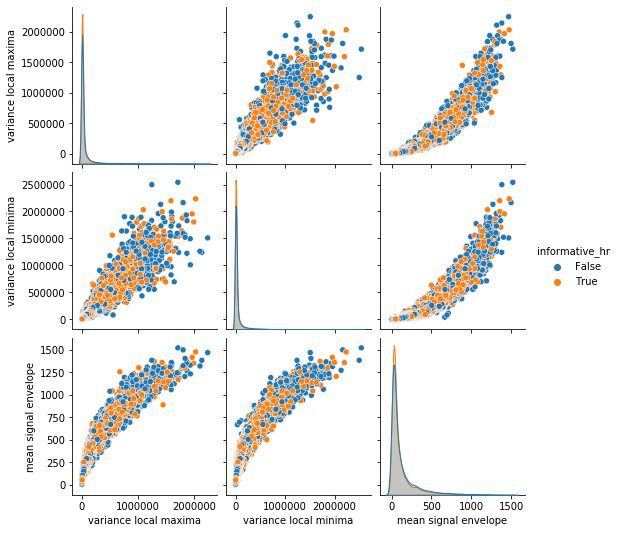

In [7]:
cols = ['variance local maxima', 'variance local minima', 'mean signal envelope', 'informative_hr']
sns.pairplot(df[cols], kind='scatter', hue='informative_hr', dropna=True)

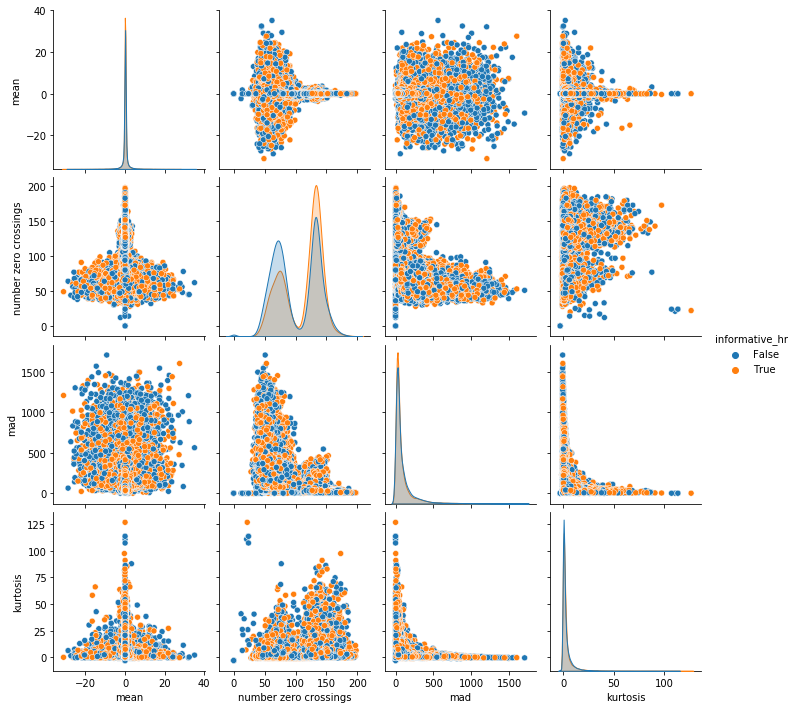

In [8]:
cols = ['mean', 'number zero crossings', 'mad', 'kurtosis', 'informative_hr']
sns.pairplot(df[cols], kind='scatter', hue='informative_hr', dropna=True)

# Boxplots features

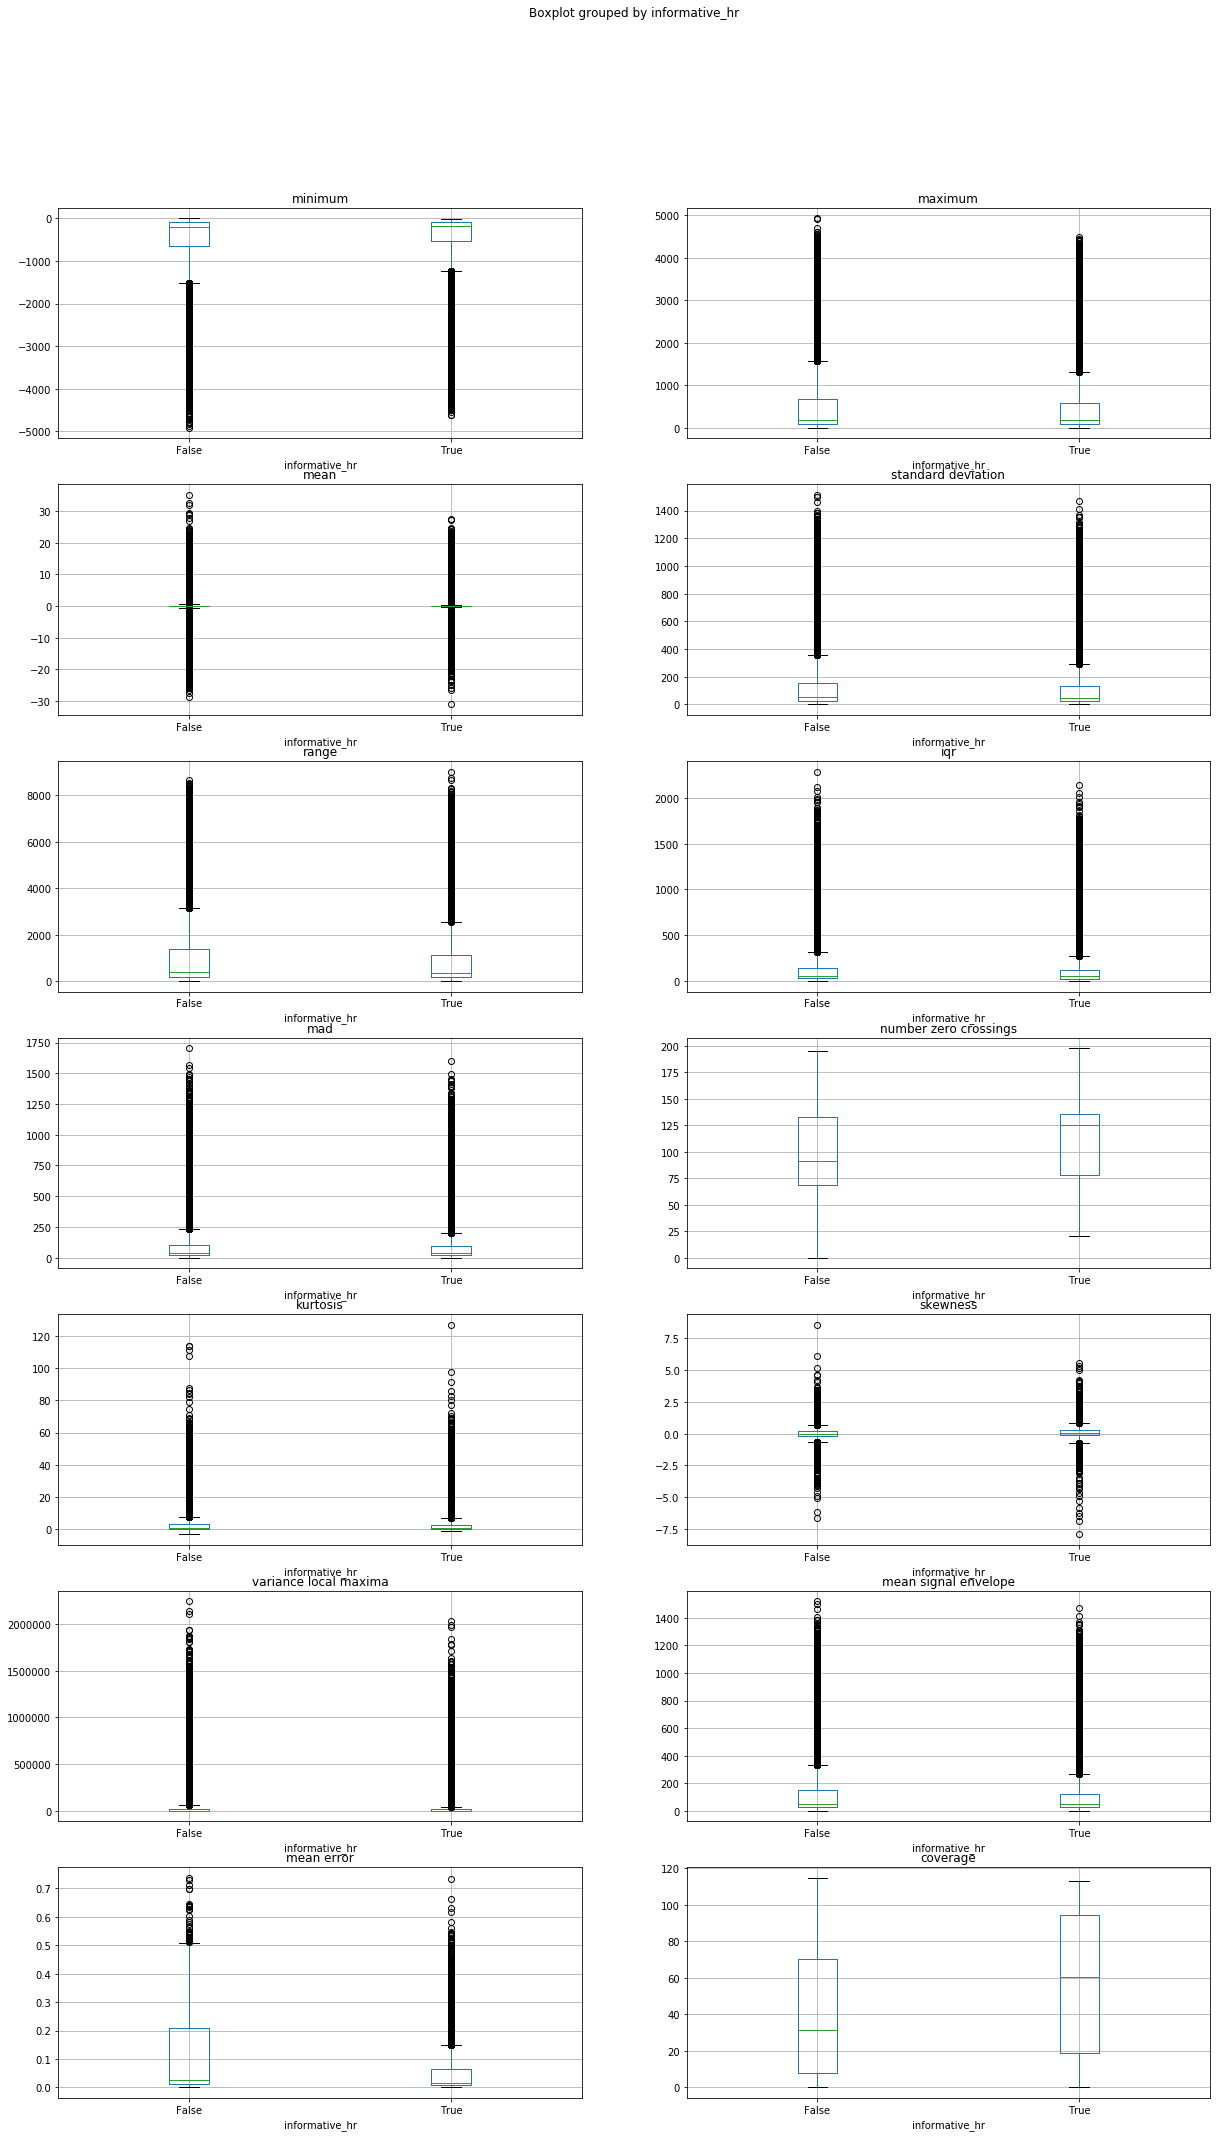

In [9]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20,35))

df.boxplot(column=['minimum'],by='informative_hr', ax=axes[0,0])
df.boxplot(column=['maximum'],by='informative_hr', ax=axes[0,1])
df.boxplot(column=['mean'],by='informative_hr', ax=axes[1,0])
df.boxplot(column=['standard deviation'],by='informative_hr', ax=axes[1,1])
df.boxplot(column=['range'],by='informative_hr', ax=axes[2,0])
df.boxplot(column=['iqr'],by='informative_hr', ax=axes[2,1])
df.boxplot(column=['mad'],by='informative_hr', ax=axes[3,0])
df.boxplot(column=['number zero crossings'],by='informative_hr', ax=axes[3,1])
df.boxplot(column=['kurtosis'],by='informative_hr', ax=axes[4,0])
df.boxplot(column=['skewness'],by='informative_hr', ax=axes[4,1])
df.boxplot(column=['variance local maxima'],by='informative_hr', ax=axes[5,0])
df.boxplot(column=['mean signal envelope'],by='informative_hr', ax=axes[5,1])
df.boxplot(column=['mean error'],by='informative_hr', ax=axes[6,0])
df.boxplot(column=['coverage'],by='informative_hr', ax=axes[6,1])
# TODO: deal with inf values


plt.show()

# Fazit
- stark korrelierende Merkmale
- Dimensionsreduktion zur Reduzierung von stark korrelierenden Merkmalen sinnvoll
- keine klare Verteilung von informativ und nicht informativ, große Überlappung

# Einfluss der Merkmale bei Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier


from src.ml_statistical_features import get_patient_split

In [11]:
forest = RandomForestClassifier(random_state=1, class_weight='balanced')
x_train, x_test, y_train, y_test, groups_train, groups_test = get_patient_split(features, target, patient_id, test_size=0.33)

forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

 1) number zero crossings          0.109700
 2) skewness                       0.088915
 3) kurtosis                       0.076857
 4) variance local maxima          0.076697
 5) variance local minima          0.076094
 6) iqr                            0.074326
 7) maximum                        0.073478
 8) mad                            0.073345
 9) minimum                        0.072554
10) range                          0.071371
11) mean                           0.070105
12) mean signal envelope           0.068346
13) standard deviation             0.068211


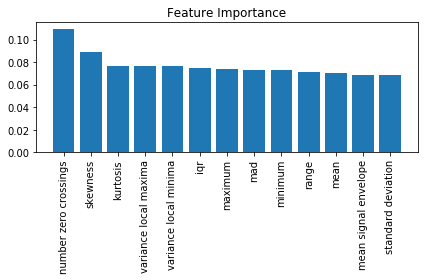

In [12]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, features.columns[indices[f]], importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(x_train.shape[1]), importances[indices], align='center')
plt.xticks(range(x_train.shape[1]), features.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()
plt.show()